most of this is borrowed code, must credit

In [1]:
import numpy as np
import xarray as xr
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import pyqg
import pyqg.diagnostic_tools
import json
import s3fs
from matplotlib.colors import TwoSlopeNorm

%matplotlib inline

# plt.rcParams.update({'font.size': 13})

In [2]:
# Datasets are hosted on globus as zarr files
def open_zarr(folder):
    for url, label in zip(['https://g-402b19.00888.8540.data.globus.org', 'https://storage.googleapis.com/m2lines-public-persistent/perezhogin-generative-zarr'], ['NYU', 'Google Cloud']):
      try:
        mapper = fsspec.get_mapper(f'{url}/{folder}.zarr')
        return xr.open_zarr(mapper, consolidated=True)
      except:
        print(f'{folder} on {label} failed')

In [3]:
hires = open_zarr('eddy/hires')
lores = open_zarr('eddy/64/lores')
hires_sharp = open_zarr('eddy/64/hires-sharp')

In [4]:
lores

<xarray.Dataset>
Dimensions:            (run: 10, l: 64, k: 33, lev: 2, time: 172, lev_mid: 1,
                        y: 64, x: 64)
Coordinates:
  * k                  (k) float32 0.0 6.283e-06 ... 0.0001948 0.0002011
  * l                  (l) float32 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev                (lev) int32 1 2
  * lev_mid            (lev_mid) float32 1.5
  * time               (time) timedelta64[ns] 41 days 16:00:00.000028800 ... ...
  * x                  (x) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Dimensions without coordinates: run
Data variables: (12/25)
    APEflux            (run, l, k) float32 dask.array<chunksize=(1, 64, 33), meta=np.ndarray>
    APEgen             (run) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    APEgenspec         (run, l, k) float32 dask.array<chunksize=(1, 64, 33), meta=np.ndarray>
    Dissspec           (run, l, k) float32 dask.array<chunksize=(1, 64, 33), meta=np.ndarray>
    EKE                (run, lev) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    EKEdiss            (run) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    ...                 ...
    paramspec_APEflux  (run, l, k) float32 dask.array<chunksize=(1, 64, 33), meta=np.ndarray>
    paramspec_KEflux   (run, l, k) float32 dask.array<chunksize=(1, 64, 33), meta=np.ndarray>
    psi                (run, time, lev, y, x) float32 dask.array<chunksize=(1, 172, 2, 64, 64), meta=np.ndarray>
    q                  (run, time, lev, y, x) float32 dask.array<chunksize=(1, 172, 2, 64, 64), meta=np.ndarray>
    u                  (run, time, lev, y, x) float32 dask.array<chunksize=(1, 172, 2, 64, 64), meta=np.ndarray>
    v                  (run, time, lev, y, x) float32 dask.array<chunksize=(1, 172, 2, 64, 64), meta=np.ndarray>
Attributes: (12/24)
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tc:         250
    pyqg:tmax:       622080000
    pyqg:twrite:     1000.0
    pyqg_params:     {'nx': 64, 'dt': 14400, 'tmax': 622080000, 'tavestart': ...
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

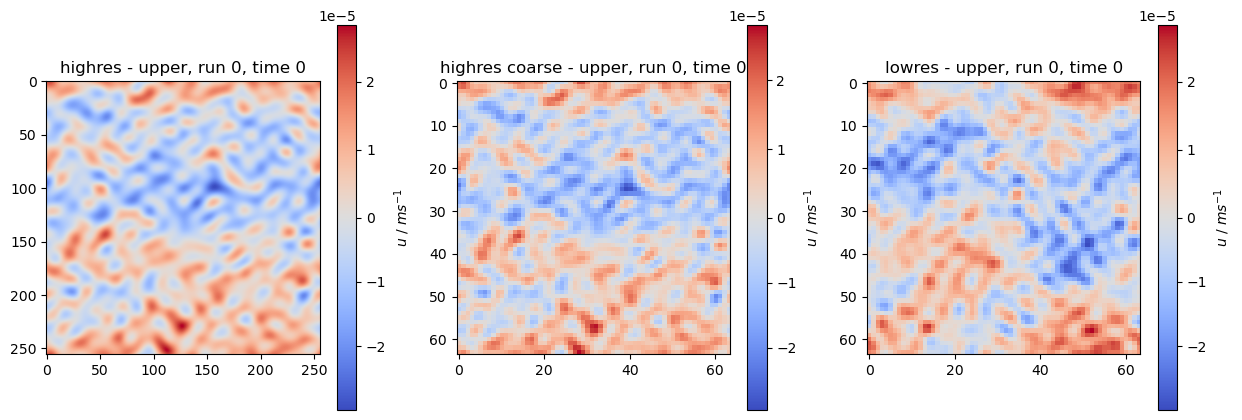

In [10]:
# what to plot
level = 1
run = 0
timestep = 0
#######

lores.u.isel(lev=level, run=run, time=timestep)

level_str = 'upper' if level == 1 else 'lower'

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
im0 = ax[0].imshow(hires.u.isel(lev=level, run=run, time=timestep), norm=TwoSlopeNorm(vcenter=0), cmap='coolwarm')
fig.colorbar(im0, ax=ax[0], label=r'$u$ / $ms^{-1}$')
ax[0].set_title(f'highres - {level_str}, run {run}, time {timestep}')
im1 = ax[1].imshow(hires_sharp.u.isel(lev=level, run=run, time=timestep), norm=TwoSlopeNorm(vcenter=0), cmap='coolwarm')
fig.colorbar(im1, ax=ax[1], label=r'$u$ / $ms^{-1}$')
ax[1].set_title(f'highres coarse - {level_str}, run {run}, time {timestep}')
im2 = ax[2].imshow(lores.u.isel(lev=level, run=run, time=timestep), norm=TwoSlopeNorm(vcenter=0), cmap='coolwarm')
fig.colorbar(im0, ax=ax[2], label=r'$u$ / $ms^{-1}$')
ax[2].set_title(f'lowres - {level_str}, run {run}, time {timestep}')

plt.show()

# training data curation

In [79]:
if False:
    # Try training on subset of data
    train_size = 5
    test_size = 2
    time_size = -5
else:
    # Full dataset
    train_size = 20
    test_size = 10
    time_size = None

ds = open_zarr('eddy/64/sharp')

train = ds.isel(run=slice(0,train_size), time=slice(time_size,None)).load()
test = ds.isel(run=slice(train_size,train_size+test_size), time=slice(time_size,None)).load()

In [80]:
train

<xarray.Dataset>
Dimensions:              (lev: 2, run: 20, time: 86, y: 64, x: 64)
Coordinates:
  * lev                  (lev) int32 1 2
  * time                 (time) timedelta64[ns] 41 days 16:00:00.000028800 .....
  * x                    (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                    (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Dimensions without coordinates: run
Data variables:
    psi                  (run, time, lev, y, x) float32 -134.6 -114.2 ... -8.273
    q                    (run, time, lev, y, x) float32 5.153e-07 ... 1.72e-06
    q_forcing_advection  (run, time, lev, y, x) float32 -8.742e-17 ... 4.043e-14
Attributes: (12/24)
    pyqg:L:          1000000.0
    pyqg:M:          65536
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tc:         86400
    pyqg:tmax:       311040000
    pyqg:twrite:     1000.0
    pyqg_params:     {'nx': 256, 'dt': 3600, 'tmax': 311040000, 'tavestart': ...
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

In [81]:
test

<xarray.Dataset>
Dimensions:              (lev: 2, run: 10, time: 86, y: 64, x: 64)
Coordinates:
  * lev                  (lev) int32 1 2
  * time                 (time) timedelta64[ns] 41 days 16:00:00.000028800 .....
  * x                    (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                    (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Dimensions without coordinates: run
Data variables:
    psi                  (run, time, lev, y, x) float32 -8.319 -13.99 ... -427.4
    q                    (run, time, lev, y, x) float32 2.206e-08 ... 1.054e-06
    q_forcing_advection  (run, time, lev, y, x) float32 3.602e-17 ... 8.536e-14
Attributes: (12/24)
    pyqg:L:          1000000.0
    pyqg:M:          65536
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tc:         86400
    pyqg:tmax:       311040000
    pyqg:twrite:     1000.0
    pyqg_params:     {'nx': 256, 'dt': 3600, 'tmax': 311040000, 'tavestart': ...
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

In [82]:
def extract(ds, key):
    var = ds[key].values
    return var.reshape(-1,*var.shape[2:])

def prepare_PV_data(ds_train, ds_test):
    '''
    Extract Potential vorticity as input ('q')
    and subgrid PV forcing ('q_forcing_advection')
    as output, and normalizes data
    '''
    X_train = extract(ds_train, 'q')
    Y_train = extract(ds_train, 'q_forcing_advection')
    X_test = extract(ds_test, 'q')
    Y_test = extract(ds_test, 'q_forcing_advection')

    print(f'std of data with level index = 0: {np.std(X_train[:, 0, :, :])}')
    print(f'std of data with level index = 1: {np.std(X_train[:, 1, :, :])}')

    x_scale = ChannelwiseScaler(X_train)
    y_scale = ChannelwiseScaler(Y_train)

    X_train = x_scale.normalize(X_train)
    X_test = x_scale.normalize(X_test)
    Y_train = y_scale.normalize(Y_train)
    Y_test = y_scale.normalize(Y_test)

    return X_train, Y_train, X_test, Y_test, x_scale, y_scale

def channelwise_function(X: np.array, fun) -> np.array:
    '''
    For array X of size 
    Nbatch x Nfeatures x Ny x Nx
    applies function "fun" for each channel
    and returns array of size
    1 x Nfeatures x 1 x 1
    '''

    N_features = X.shape[1]
    out = np.zeros((1,N_features,1,1))
    for n_f in range(N_features):
        out[0,n_f,0,0] = fun(X[:,n_f,:,:])

    return out.astype('float32')

def channelwise_std(X: np.array) -> np.array:
    '''
    For array X of size 
    Nbatch x Nfeatures x Ny x Nx
    Computes standard deviation for each channel
    with double precision
    and returns array of size
    1 x Nfeatures x 1 x 1
    '''
    return channelwise_function(X.astype('float64'), np.std)

def channelwise_mean(X: np.array) -> np.array:
    '''
    For array X of size 
    Nbatch x Nfeatures x Ny x Nx
    Computes mean for each channel
    with double precision
    and returns array of size
    1 x Nfeatures x 1 x 1
    '''
    return channelwise_function(X.astype('float64'), np.mean)

class ChannelwiseScaler:
    '''
    Class containing std and mean
    values for each channel
    '''
    def __init__(self, X=None):
        ''' 
        Stores std and mean values.
        X is numpy array of size
        Nbatch x Nfeatures x Ny x Nx.
        '''
        if X is not None:
            self.mean = channelwise_mean(X)
            self.std  = channelwise_std(X)
    def normalize(self, X):
        '''
        Divide by std
        '''
        return X / self.std

In [83]:
x_train, y_train, x_test, y_test, x_scale, y_scale = prepare_PV_data(train, test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

std of data with level index = 0: 7.996431122592185e-06
std of data with level index = 1: 1.055853772413684e-06
(1720, 2, 64, 64) (1720, 2, 64, 64) (860, 2, 64, 64) (860, 2, 64, 64)


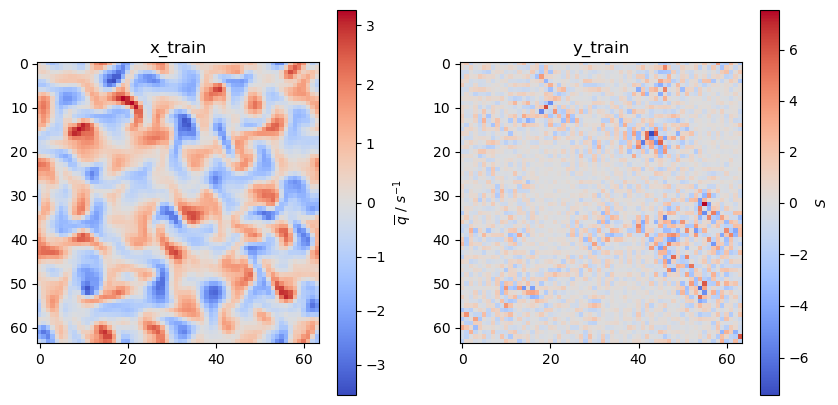

(array([6.200000e+01, 3.410000e+03, 8.201000e+04, 6.878320e+05,
        2.302991e+06, 3.050498e+06, 8.061840e+05, 1.069880e+05,
        5.073000e+03, 7.200000e+01]),
 array([-5.86737633, -4.70553017, -3.54368424, -2.38183808, -1.21999204,
        -0.058146  ,  1.10370004,  2.26554608,  3.42739224,  4.58923817,
         5.75108433]),
 <BarContainer object of 10 artists>)

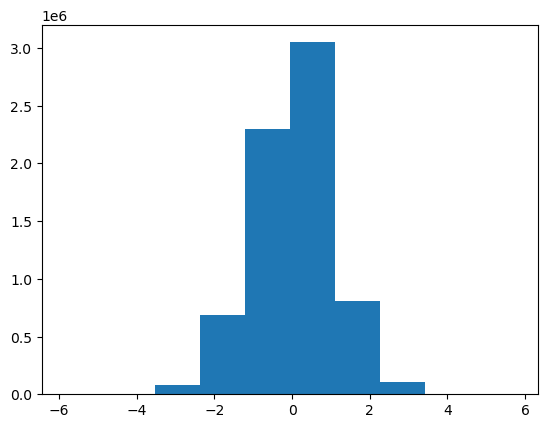

In [85]:
# what to plot
# level = 0 -> upper layer
# level = 1 -> lower layer
level = 1
index_to_plot = 128
#######

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, level, :, :], norm=TwoSlopeNorm(vcenter=0), cmap='coolwarm')
fig.colorbar(im0, ax=ax[0], label=r'$\overline{q}$ / $s^{-1}$')
ax[0].set_title(f'x_train')

im1 = ax[1].imshow(y_train[index_to_plot, level, :, :], norm=TwoSlopeNorm(vcenter=0), cmap='coolwarm')
fig.colorbar(im1, ax=ax[1], label=r'$S$')
ax[1].set_title(f'y_train')


plt.show()

plt.hist(x_train[:, level, :, :].flatten())

In [2]:
import numpy as np
import pywt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Example data for Field 1 and Field 2 (replace with actual data)
field1 = np.random.randn(100, 100)  # Replace with actual field data
field2 = np.random.randn(100, 100)  # Replace with actual field data

# PCA for Field 1
def pca_decomposition(field, n_components=10):
    pca = PCA(n_components=n_components)
    flattened_field = field.flatten()
    reshaped_field = flattened_field.reshape(1, -1)
    pca.fit(reshaped_field)
    transformed = pca.transform(reshaped_field)
    reconstructed = pca.inverse_transform(transformed)
    return reconstructed.reshape(field.shape)

# Wavelet Transform for Field 2
def wavelet_decomposition(field, wavelet='db1', level=2):
    coeffs = pywt.wavedec2(field, wavelet, level=level)
    coeffs_thresh = coeffs[:1] + [pywt.threshold(c, np.std(c)/2) for c in coeffs[1:]]
    reconstructed = pywt.waverec2(coeffs_thresh, wavelet)
    return reconstructed

# Apply the decompositions
# reconstructed_field1 = pca_decomposition(field1)
reconstructed_field2 = wavelet_decomposition(field2)

# Plot the results
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(field1, cmap='coolwarm')
plt.title('Field 1')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(field2, cmap='coolwarm')
plt.title('Field 2')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(reconstructed_field1, cmap='coolwarm')
plt.title('Reconstructed Field 1 (PCA)')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(reconstructed_field2, cmap='coolwarm')
plt.title('Reconstructed Field 2 (Wavelet)')
plt.colorbar()

plt.show()

ValueError: Unexpected detail coefficient type: <class 'numpy.ndarray'>. Detail coefficients must be a 3-tuple of arrays as returned by wavedec2. If you are using pywt.array_to_coeffs or pywt.unravel_coeffs, please specify output_format='wavedec2'